## EMA 与 MACD 配合使用

MACD 是基于 EMA 的动量指标，由快线（MACD 线）、慢线（信号线）和柱状图（Histogram）组成。

#### 使用方法：
+ 当 MACD 线（快线）上穿信号线（慢线）时，可能是买入信号。
+ 当 MACD 线下穿信号线时，可能是卖出信号。
结合 EMA（如 12 日和 26 日 EMA），可以进一步确认趋势方向。

In [92]:
# 获取数据源
import baostock as bs
import pandas as pd
import logging
import numpy as np

def get_k_data(code, start, end):
    lg = bs.login()
    # 显示登陆返回信息
    logging.info('login respond error_code:' + lg.error_code)
    logging.info('login respond  error_msg:' + lg.error_msg)
    # 获取股票数据
    rs = bs.query_history_k_data_plus(code,
                                              "date,open,high,low,close,volume",
                                              start_date=start,
                                              end_date=end,
                                              frequency="d",
                                              adjustflag="3")  # adjustflag="3"表示不复权
    data = rs.get_data()


    # 登出baostock系统
    bs.logout()

    # 创建DataFrame
    df = data[['date', 'open', 'high', 'low', 'close', 'volume']].rename(columns={'date': 'Date'})

    # 转换日期格式
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)  # 设置日期列为索引

    # 将空字符串替换为 NaN
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].replace('', np.nan)
    # 去除包含空值的行
    df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

    # 将股价数据转换为数值类型
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df


In [93]:
stock_code = "sh.603486"  # 沪深300
start_date = "2024-01-01"
end_date = "2025-12-31"

df = get_k_data(stock_code, start_date, end_date)

login success!
logout success!


In [94]:
import talib

# 计算MACD
# 解释下 MACD 的参数：fastperiod=12, slowperiod=26, signalperiod=9
# fastperiod：快速移动平均线的窗口期
# slowperiod：慢速移动平均线的窗口期
# signalperiod：MACD的窗口期

# 返回结果是什么？
# MACD：MACD线
# MACD_signal：MACD的信号线
# MACD_hist：MACD的差值，即MACD线和信号线的差值
# 怎么用？ 

df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)


# 计算20日指数移动平均线
df['EMA_20'] = talib.EMA(df['close'], timeperiod=20)

# 计算60日指数移动平均线
df['EMA_60'] = talib.EMA(df['close'], timeperiod=60)


In [95]:
df['EMA_20']

Date
2024-01-02          NaN
2024-01-03          NaN
2024-01-04          NaN
2024-01-05          NaN
2024-01-08          NaN
                ...    
2025-03-03    55.245410
2025-03-04    55.507752
2025-03-05    55.771775
2025-03-06    55.987797
2025-03-07    56.068959
Name: EMA_20, Length: 283, dtype: float64

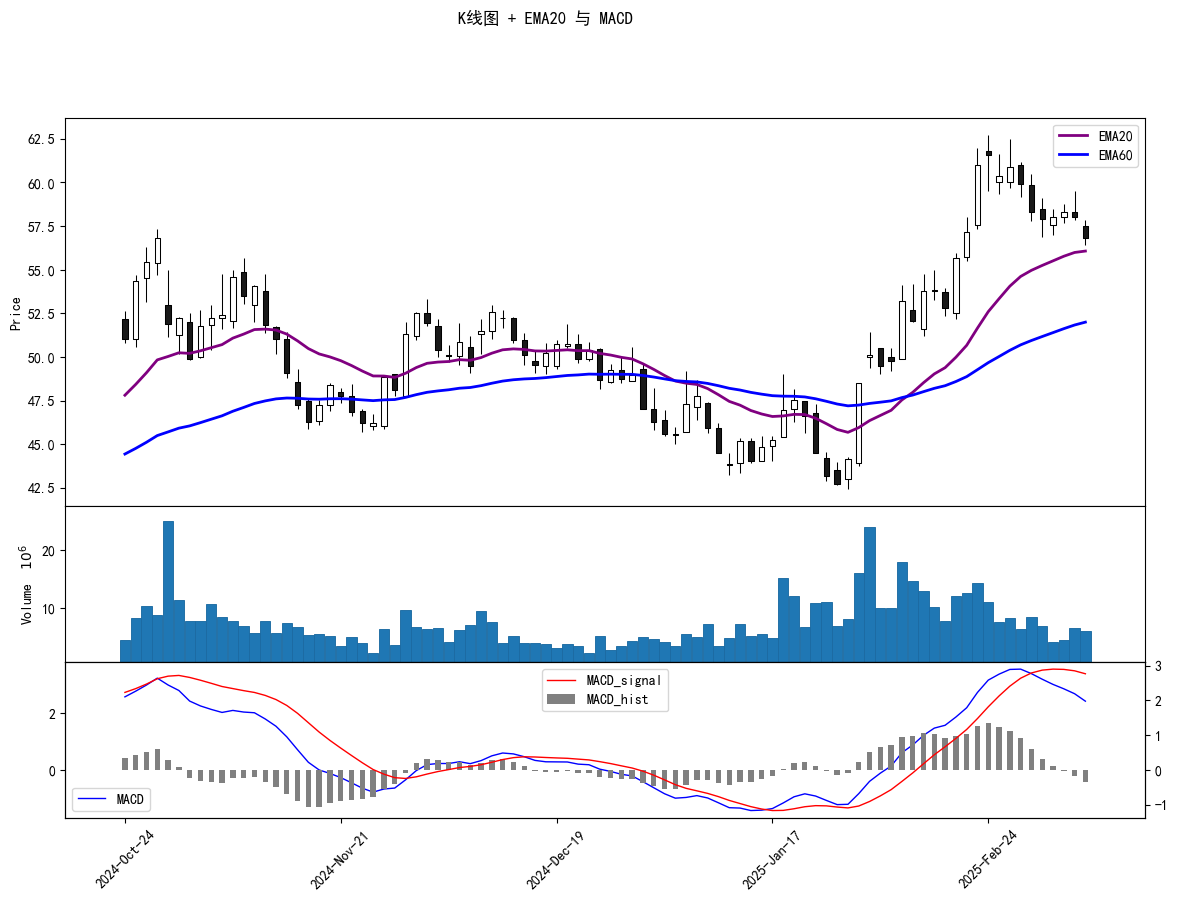

In [96]:
import mplfinance as mpf
import matplotlib.pyplot as plt

# 找到买卖点
# 策略说明
# buy_signal 在 MACD 线上穿 MACD_signal 时为 True，表示买入。
# sell_signal 在 MACD 线下穿 MACD_signal 时为 True，表示卖出。
df['buy_signal'] = (df['MACD'] > df['MACD_signal']) & (df['MACD'].shift(1) <= df['MACD_signal'].shift(1))
df['sell_signal'] = (df['MACD'] < df['MACD_signal']) & (df['MACD'].shift(1) >= df['MACD_signal'].shift(1))

# 进一步优化：使用柱状图辅助判断趋势
# strong_buy 结合 MACD_hist 确保上涨动能，strong_sell 结合 MACD_hist 确保下跌动能，减少误判。
df['strong_buy'] = (df['buy_signal']) & (df['MACD_hist'] > 0)
df['strong_sell'] = (df['sell_signal']) & (df['MACD_hist'] < 0)


# 只要90天
df = df.tail(90)


# 创建附加图
# 在主面板上添加 EMA20
ap_ema20 = mpf.make_addplot(df['EMA_20'], panel=0, color='purple', width=2, ylabel='Price',label='EMA20')
ap_ema60 = mpf.make_addplot(df['EMA_60'], panel=0, color='blue', width=2, ylabel='Price',label='EMA60')

# 在第二个面板（panel=1）中添加 MACD 相关数据
ap_macd    = mpf.make_addplot(df['MACD'], panel=2, color='blue', width=1, label='MACD')
ap_macds   = mpf.make_addplot(df['MACD_signal'], panel=2, color='red', width=1, label='MACD_signal')
ap_macdhist= mpf.make_addplot(df['MACD_hist'], panel=2,  type='bar', color='gray', width=0.5, label='MACD_hist')  

# https://github.com/Ted88368/quant_in_action.git

# 创建自定义风格，设置中文字体
my_style = mpf.make_mpf_style(rc={'font.sans-serif': ['SimHei'],
                                  'axes.unicode_minus': False})



# 绘制图表，返回 figure 和 axes 列表
fig, axes = mpf.plot(df, type='candle', style=my_style,addplot=[ap_ema20, ap_ema60,ap_macd, ap_macds,ap_macdhist],
                       volume=True, returnfig=True, figsize=(15,10),
                       title='K线图 + EMA20 与 MACD')

plt.show()
